# 01 — Khám phá dữ liệu (EDA): NYC Airbnb 2019

**Mục tiêu**
- Nắm cấu trúc dữ liệu: kích thước, các cột, kiểu dữ liệu, thiếu/khác thường
- Thống kê mô tả các biến số; phân phối *price*, *minimum_nights*, ...
- Quan sát tương quan và các mẫu đơn giản theo *neighbourhood_group*, *room_type*
- Trực quan hóa cơ bản (Matplotlib/Seaborn) - xử lý **chỉ bằng NumPy**

In [1]:
# Xác định ROOT sao cho linh hoạt khi mở notebook từ project 
from pathlib import Path
import sys

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

print(ROOT)
sys.path.insert(0, str(ROOT))

/home/khoaoe/HCMUS/HK5/DS_Programming/lab/lab02/hcmus-csc17104-airbnb-data-analysis


## 0) Khởi tạo & import

In [2]:
import numpy as np

# Import các API đã chuẩn hóa trong src/__init__.py
from src import (
    load_airbnb, find_csv, to_columns,
    numeric_cols, categorical_cols,
    missing_summary, unique_summary, describe_numeric,
    groupby_reduce, topk_counts, corr_matrix,
    plot_hist, plot_bar_counts, plot_scatter_geo,
    plot_corr_heatmap, plot_box_by_cat, 
    plot_bar_values,
)

# data path
DATA_ROOT = ROOT / "data" / "raw"

## 1) Nạp dữ liệu & kiểm tra nhanh

- Đọc CSV → dict `{column -> ndarray}`, trong đó cột ngày đã parse sang `datetime64[D]`.
- Kiểm tra kích thước, danh sách cột, kiểu dữ liệu.

In [3]:
# Load dữ liệu
csv_path = find_csv(str(DATA_ROOT)) if DATA_ROOT.exists() else str(ROOT / "data" / "AB_NYC_2019.csv")
cols = load_airbnb(csv_path)

# Kích thước & danh sách cột
n_rows = len(next(iter(cols.values())))
col_names = list(cols.keys())

print(f"File: {csv_path}")
print(f"Số dòng: {n_rows}")
print(f"Số cột : {len(col_names)}")
print("Các cột :", col_names[:])

# In kiểu dữ liệu từng cột (NumPy dtype)
print("\nKiểu dữ liệu:")
for k, v in cols.items():
    print(f"  - {k:30s}: {v.dtype}")

File: /home/khoaoe/HCMUS/HK5/DS_Programming/lab/lab02/hcmus-csc17104-airbnb-data-analysis/data/raw/AB_NYC_2019.csv
Số dòng: 48895
Số cột : 16
Các cột : ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Kiểu dữ liệu:
  - id                            : float64
  - name                          : <U179
  - host_id                       : float64
  - host_name                     : <U35
  - neighbourhood_group           : <U13
  - neighbourhood                 : <U26
  - latitude                      : float64
  - longitude                     : float64
  - room_type                     : <U15
  - price                         : float64
  - minimum_nights                : float64
  - number_of_reviews             : float64
  - last_review                   : datetime64[D]
  - reviews_pe

## 2) Quan sát 5 dòng đầu (theo cột quan trọng)

- In nhanh một số cột thường dùng để EDA: `id, name, neighbourhood_group, neighbourhood, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month`.

In [4]:
# In 5 bản ghi đầu, chọn subset cột thường dùng
show_cols = [
    "id", "name", "neighbourhood_group", "neighbourhood",
    "room_type", "price", "minimum_nights", "number_of_reviews",
    "last_review", "reviews_per_month"
]
show_cols = [c for c in show_cols if c in cols]

k = min(5, n_rows)
for i in range(k):
    row = {c: cols[c][i] for c in show_cols}
    print(row)

{'id': np.float64(2539.0), 'name': np.str_('Clean & quiet apt home by the park'), 'neighbourhood_group': np.str_('Brooklyn'), 'neighbourhood': np.str_('Kensington'), 'room_type': np.str_('Private room'), 'price': np.float64(149.0), 'minimum_nights': np.float64(1.0), 'number_of_reviews': np.float64(9.0), 'last_review': np.datetime64('2018-10-19'), 'reviews_per_month': np.float64(0.21)}
{'id': np.float64(2595.0), 'name': np.str_('Skylit Midtown Castle'), 'neighbourhood_group': np.str_('Manhattan'), 'neighbourhood': np.str_('Midtown'), 'room_type': np.str_('Entire home/apt'), 'price': np.float64(225.0), 'minimum_nights': np.float64(1.0), 'number_of_reviews': np.float64(45.0), 'last_review': np.datetime64('2019-05-21'), 'reviews_per_month': np.float64(0.38)}
{'id': np.float64(3647.0), 'name': np.str_('THE VILLAGE OF HARLEM....NEW YORK !'), 'neighbourhood_group': np.str_('Manhattan'), 'neighbourhood': np.str_('Harlem'), 'room_type': np.str_('Private room'), 'price': np.float64(150.0), 'mini

## 3) Thiếu dữ liệu & tính duy nhất ở cột phân loại

- **Thiếu dữ liệu**: đếm số lượng và tỷ lệ % theo cột.
- **Số giá trị khác nhau**: với cột phân loại (`name, host_name, neighbourhood_group, neighbourhood, room_type`).


In [5]:
# Tóm tắt thiếu dữ liệu
miss_tbl = missing_summary(cols)
print("Tóm tắt thiếu dữ liệu theo cột:")
print(miss_tbl)

# %% Unique summary cho cột phân loại
uniq_tbl = unique_summary(cols, categorical_cols)
print("\nSố giá trị khác nhau ở cột phân loại:")
print(uniq_tbl)

Tóm tắt thiếu dữ liệu theo cột:
[('id',     0,  0.        ) ('name',    16,  0.03272318)
 ('host_id',     0,  0.        ) ('host_name',    21,  0.04294918)
 ('neighbourhood_group',     0,  0.        )
 ('neighbourhood',     0,  0.        ) ('latitude',     0,  0.        )
 ('longitude',     0,  0.        ) ('room_type',     0,  0.        )
 ('price',     0,  0.        ) ('minimum_nights',     0,  0.        )
 ('number_of_reviews',     0,  0.        )
 ('last_review', 10052, 20.5583393 )
 ('reviews_per_month', 10052, 20.5583393 )
 ('calculated_host_listings_count',     0,  0.        )
 ('availability_365',     0,  0.        )]

Số giá trị khác nhau ở cột phân loại:
[('name', 47895, 9.79548011e+01) ('host_name', 11453, 2.34236630e+01)
 ('neighbourhood_group',     5, 1.02259945e-02)
 ('neighbourhood',   221, 4.51988956e-01)
 ('room_type',     3, 6.13559669e-03)]


## 4) Thống kê mô tả các biến số

- Dùng NumPy để tính `min, p25, p50, p75, max, mean, std`.
- Tập cột số mặc định: `id, host_id, latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365`.

In [6]:
# Describe numeric (NumPy only)
desc_tbl = describe_numeric(cols, numeric_cols)
print("Thống kê mô tả (cột số):")
print(desc_tbl)

Thống kê mô tả (cột số):
[('id',  2.539000e+03,  9.471945e+06,  1.9677284e+07,  2.91521785e+07,  3.64872450e+07,  1.90171432e+07, 1.09831084e+07)
 ('host_id',  2.438000e+03,  7.822033e+06,  3.0793816e+07,  1.07434423e+08,  2.74321313e+08,  6.76200106e+07, 7.86109670e+07)
 ('latitude',  4.049979e+01,  4.069010e+01,  4.0723070e+01,  4.07631150e+01,  4.09130600e+01,  4.07289489e+01, 5.45300781e-02)
 ('longitude', -7.424442e+01, -7.398307e+01, -7.3955680e+01, -7.39362750e+01, -7.37129900e+01, -7.39521696e+01, 4.61567361e-02)
 ('price',  0.000000e+00,  6.900000e+01,  1.0600000e+02,  1.75000000e+02,  1.00000000e+04,  1.52720687e+02, 2.40154170e+02)
 ('minimum_nights',  1.000000e+00,  1.000000e+00,  3.0000000e+00,  5.00000000e+00,  1.25000000e+03,  7.02996216e+00, 2.05105495e+01)
 ('number_of_reviews',  0.000000e+00,  1.000000e+00,  5.0000000e+00,  2.40000000e+01,  6.29000000e+02,  2.32744657e+01, 4.45505823e+01)
 ('reviews_per_month',  1.000000e-02,  1.900000e-01,  7.2000000e-01,  2.02000000

## 5) Trực quan phân phối & quan hệ cơ bản

- **Histogram** cho `price` (thử thêm log-scale để nhìn rõ đuôi dài).
- **Bar chart** Top-10 `neighbourhood_group` / `room_type`.
- **Geo scatter**: phân bố điểm theo (lon, lat), tô màu theo `price`.
- **Boxplot**: `price` theo `room_type` để thấy khác biệt theo loại phòng.


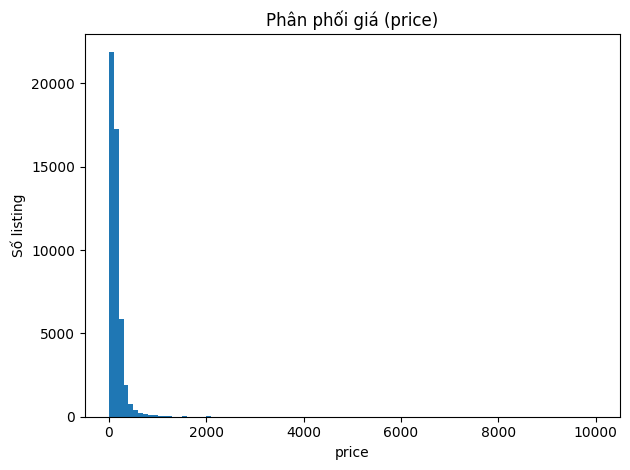

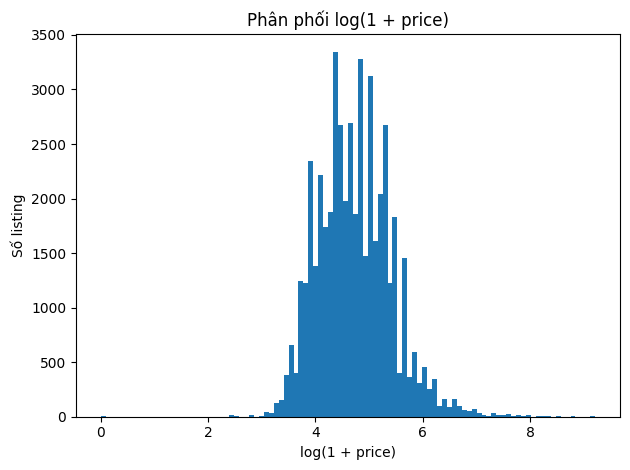

In [7]:
# Histogram phân phối price
price = cols["price"].astype(float)

plot_hist(
    price,
    bins=100,
    title="Phân phối giá (price)",
    xlabel="price",
    ylabel="Số listing"
)

# log-scale để thấy rõ đuôi
plot_hist(
    np.log1p(price),
    bins=100,
    title="Phân phối log(1 + price)",
    xlabel="log(1 + price)",
    ylabel="Số listing"
)

**Nhận xét:**

- Sau khi lấy log, phân phối `log(1 + price)` khá đối xứng, gần giống dạng chuông -> giá gốc bị lệch phải (có nhiều listing đắt)
- Phần lớn listing nằm trong vùng `log(1 + price) ≈ 4–6`, tương ứng khoảng ~50–400 USD/đêm

## Các câu hỏi đặt ra

1. Khu vực (neighbourhood_group) nào có giá thuê trung bình cao/thấp?
2. Loại phòng (room_type) nào phù hợp với ngân sách thấp / cao?

Giá thuê trung bình theo neighbourhood_group (USD/đêm):
- Manhattan      :    196.9
- Brooklyn       :    124.4
- Staten Island  :    114.8
- Queens         :     99.5
- Bronx          :     87.6


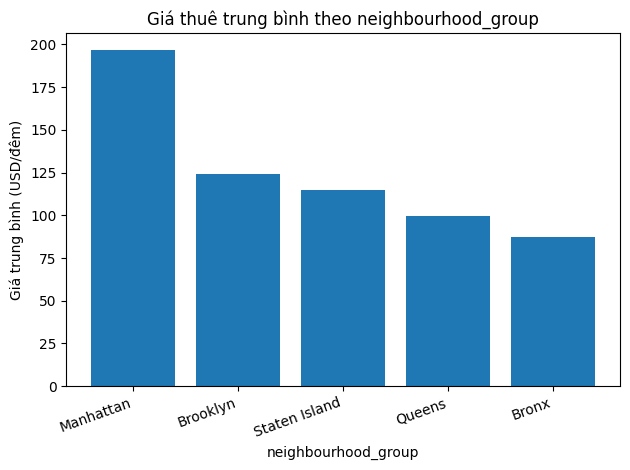

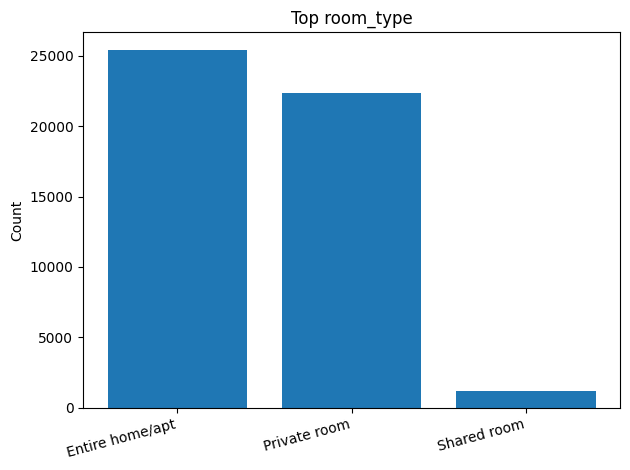

In [8]:
# Bar chart tần suất theo nhóm
# 1) Giá thuê trung bình theo khu vực (neighbourhood_group)
neigh = cols["neighbourhood_group"]
price = cols["price"].astype(float)

# Lọc giá hợp lệ > 0
mask = np.isfinite(price) & (price > 0)
neigh_valid = neigh[mask]
price_valid = price[mask]

# Tính giá trung bình theo khu vực
neigh_keys, neigh_mean_price = groupby_reduce(
    neigh_valid,
    price_valid,
    how="mean",
)

# Sắp xếp khu vực theo giá giảm dần
order = np.argsort(-neigh_mean_price)
neigh_sorted = neigh_keys[order]
mean_sorted = neigh_mean_price[order]

print("Giá thuê trung bình theo neighbourhood_group (USD/đêm):")
for n, m in zip(neigh_sorted, mean_sorted):
    print(f"- {n:15s}: {m:8.1f}")

# plot
plot_bar_values(
    categories=neigh_sorted,
    values=mean_sorted,
    title="Giá thuê trung bình theo neighbourhood_group",
    xlabel="neighbourhood_group",
    ylabel="Giá trung bình (USD/đêm)",
    sort_by="value",
    ascending=False,
    rotation=20,
)

# 2) theo loại phòng
plot_bar_counts(cols["room_type"], topk=10, title="Top room_type", rotation=15)

**Nhận xét:**

- Listing tập trung chủ yếu ở **Manhattan** và **Brooklyn**, chiếm phần lớn tổng số listing của dataset
- **Queens** có số lượng vừa phải, trong khi **Bronx** và **Staten Island** rất ít.
- Hai loại phòng chính là **Entire home/apt** và **Private room**, chiếm gần như toàn bộ
- **Shared room** là loại rất hiếm

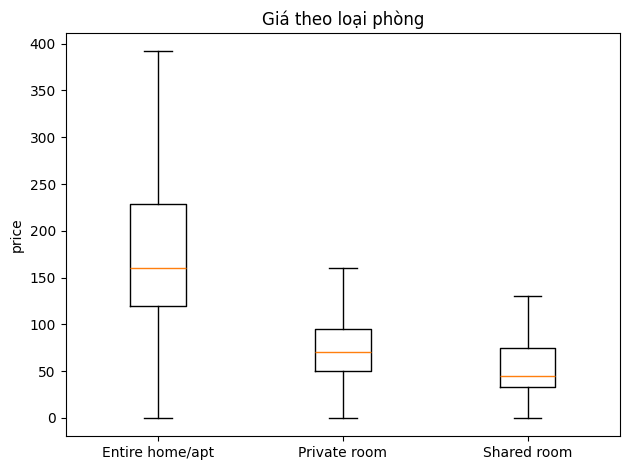

In [9]:
# Boxplot price ~ room_type (ẩn outlier để nhìn median rõ hơn)
plot_box_by_cat(cols["price"].astype(float), cols["room_type"], title="Giá theo loại phòng", ylabel="price")

**Nhận xét:**

- **Entire home/apt** có median price cao nhất và khoảng giá trải rộng -> nhiều lựa chọn 
- **Private room** rẻ hơn rõ, median thấp hơn và IQR nhỏ hơn
- **Shared room** là phân khúc rẻ nhất

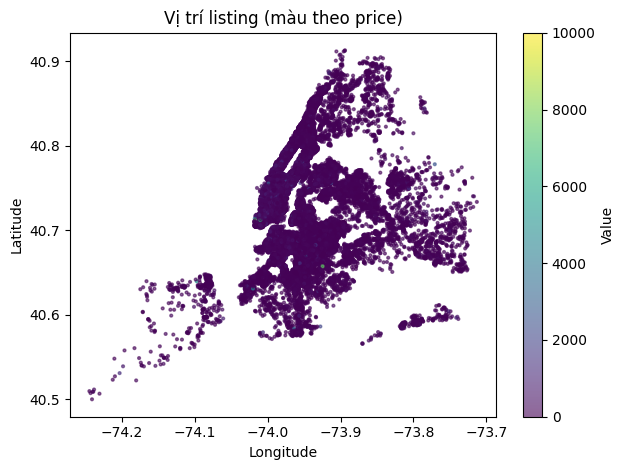

In [10]:
# Scatter địa lý (lon, lat) tô màu theo price
plot_scatter_geo(cols["latitude"], cols["longitude"], c=cols["price"], s=4, title="Vị trí listing (màu theo price)")

**Nhận xét:**

- Phủ kín khắp New York, mật độ dày đặc tại khu trung tâm (đặc biệt là Manhattan) và dọc bờ sông ở Brooklyn/Queens

## 6) Tương quan giữa các biến số

- Chọn một tập biến số thường liên quan đến giá:  
  `["price","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365"]`
- Tính ma trận tương quan Pearson (bỏ hàng có NaN) và vẽ heatmap

Using seaborn for heatmap visualization


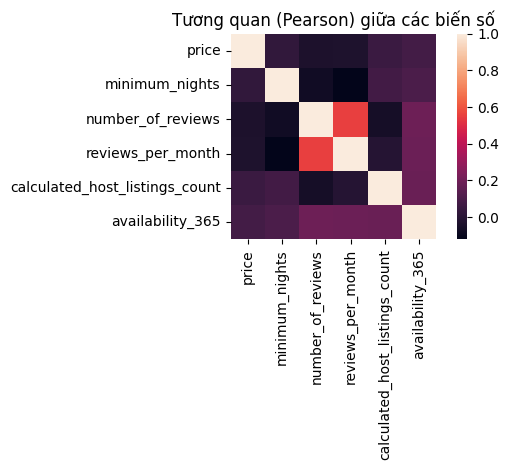

In [11]:
# Corr matrix + heatmap
num_for_corr = [
    "price", "minimum_nights", "number_of_reviews", "reviews_per_month",
    "calculated_host_listings_count", "availability_365"
]
C, labels = corr_matrix(cols, num_for_corr)

plot_corr_heatmap(C, labels, title="Tương quan (Pearson) giữa các biến số")

**Nhận xét:**

- `price` không có tương quan tuyến tính mạnh với các feature còn lại => khó dùng riêng cá feature này để dự đoán giá bằng mô hình tuyến tính 
- `number_of_reviews` và `reviews_per_month` tương quan dương khá rõ: listing có nhiều review tổng thì thường nhận review đều đặn hơn
- `reviews_per_month` có tương quan âm với `availability_365`: những listing được đặt nhiều (nhiều review/tháng) sẽ ít ngày trống hơn trong năm